In [26]:
import sqlite3
import pandas as pd
import re
import numpy as np
import os
from scipy.stats import f_oneway
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from scipy import stats


In [27]:
db_path = "data/agri.db"  
conn = sqlite3.connect(db_path)

Show all tables in the database

In [28]:
query = "SELECT * FROM farm_data;"
df = pd.read_sql(query, conn)

print(df)

      System Location Code Previous Cycle Plant Type           Plant Type  \
0                   Zone_D                     Herbs           Vine Crops   
1                   Zone_G                     Herbs           VINE CROPS   
2                   Zone_F                     Herbs                herbs   
3                   Zone_G                     Herbs  fruiting vegetables   
4                   Zone_B                Vine Crops         LEAFY GREENS   
...                    ...                       ...                  ...   
57484               Zone_C                Vine Crops  Fruiting Vegetables   
57485               Zone_C                Vine Crops  Fruiting Vegetables   
57486               Zone_E                     Herbs           VINE CROPS   
57487               Zone_G       Fruiting Vegetables           VINE CROPS   
57488               Zone_F       Fruiting Vegetables         Leafy Greens   

      Plant Stage  Temperature Sensor (°C)  Humidity Sensor (%)  \
0       

1. Preparing the Data

In [29]:
df.dtypes

System Location Code             object
Previous Cycle Plant Type        object
Plant Type                       object
Plant Stage                      object
Temperature Sensor (°C)         float64
Humidity Sensor (%)             float64
Light Intensity Sensor (lux)    float64
CO2 Sensor (ppm)                  int64
EC Sensor (dS/m)                float64
O2 Sensor (ppm)                   int64
Nutrient N Sensor (ppm)          object
Nutrient P Sensor (ppm)          object
Nutrient K Sensor (ppm)          object
pH Sensor                       float64
Water Level Sensor (mm)         float64
dtype: object

Cleaning and preparing the data

In [30]:
remove_ppm = ["Nutrient N Sensor (ppm)", "Nutrient P Sensor (ppm)", "Nutrient K Sensor (ppm)"]

for col in remove_ppm:
    df[col] = (
        df[col]
        .astype(str)  # Convert all values to string
        .str.replace("ppm", "", regex=False)  # Remove 'ppm'
        .str.strip()  # Remove whitespace
        .replace(["", "None", "nan"], pd.NA)  # Replace empty strings and 'None' with Pandas NA
        .astype("Int64")  # Convert to integer while keeping NaNs
    )

df.dtypes


System Location Code             object
Previous Cycle Plant Type        object
Plant Type                       object
Plant Stage                      object
Temperature Sensor (°C)         float64
Humidity Sensor (%)             float64
Light Intensity Sensor (lux)    float64
CO2 Sensor (ppm)                  int64
EC Sensor (dS/m)                float64
O2 Sensor (ppm)                   int64
Nutrient N Sensor (ppm)           Int64
Nutrient P Sensor (ppm)           Int64
Nutrient K Sensor (ppm)           Int64
pH Sensor                       float64
Water Level Sensor (mm)         float64
dtype: object

In [31]:
object_columns = ["System Location Code","Previous Cycle Plant Type","Plant Type", "Plant Stage"]

for col in object_columns:
    df[col] = df[col].astype(str).str.strip().str.title()
    df[f"new_{col}"] = pd.factorize(df[col])[0]  # Assign unique integer values

df[[f"new_{col}" for col in object_columns]] = df[[f"new_{col}" for col in object_columns]].astype("int64")
df.dtypes

System Location Code              object
Previous Cycle Plant Type         object
Plant Type                        object
Plant Stage                       object
Temperature Sensor (°C)          float64
Humidity Sensor (%)              float64
Light Intensity Sensor (lux)     float64
CO2 Sensor (ppm)                   int64
EC Sensor (dS/m)                 float64
O2 Sensor (ppm)                    int64
Nutrient N Sensor (ppm)            Int64
Nutrient P Sensor (ppm)            Int64
Nutrient K Sensor (ppm)            Int64
pH Sensor                        float64
Water Level Sensor (mm)          float64
new_System Location Code           int64
new_Previous Cycle Plant Type      int64
new_Plant Type                     int64
new_Plant Stage                    int64
dtype: object

Change object type into int type for analysis

In [32]:
df_new = df.drop(columns=object_columns)
df_new.dtypes


Temperature Sensor (°C)          float64
Humidity Sensor (%)              float64
Light Intensity Sensor (lux)     float64
CO2 Sensor (ppm)                   int64
EC Sensor (dS/m)                 float64
O2 Sensor (ppm)                    int64
Nutrient N Sensor (ppm)            Int64
Nutrient P Sensor (ppm)            Int64
Nutrient K Sensor (ppm)            Int64
pH Sensor                        float64
Water Level Sensor (mm)          float64
new_System Location Code           int64
new_Previous Cycle Plant Type      int64
new_Plant Type                     int64
new_Plant Stage                    int64
dtype: object

Checking for missing values percentage

In [33]:
for col in df_new.columns:
    missing_percentage = (df_new[col].isnull().sum() / len(df_new)) * 100
    print(f"Percentage of missing values in '{col}': {missing_percentage:.2f}%")

Percentage of missing values in 'Temperature Sensor (°C)': 15.11%
Percentage of missing values in 'Humidity Sensor (%)': 67.61%
Percentage of missing values in 'Light Intensity Sensor (lux)': 7.44%
Percentage of missing values in 'CO2 Sensor (ppm)': 0.00%
Percentage of missing values in 'EC Sensor (dS/m)': 0.00%
Percentage of missing values in 'O2 Sensor (ppm)': 0.00%
Percentage of missing values in 'Nutrient N Sensor (ppm)': 17.35%
Percentage of missing values in 'Nutrient P Sensor (ppm)': 9.91%
Percentage of missing values in 'Nutrient K Sensor (ppm)': 6.44%
Percentage of missing values in 'pH Sensor': 0.00%
Percentage of missing values in 'Water Level Sensor (mm)': 15.03%
Percentage of missing values in 'new_System Location Code': 0.00%
Percentage of missing values in 'new_Previous Cycle Plant Type': 0.00%
Percentage of missing values in 'new_Plant Type': 0.00%
Percentage of missing values in 'new_Plant Stage': 0.00%


We can see that column "Humidity Sensor (%)" has a missing value percentage of 67.61% which is quite high. The column might be irrelvant for analysis.
For columns like "Temperature Sensor (%)", "Light Intensity Sensor (lux)", "Nutrient N Sensor (ppm)", "Nutrient K Sensor (ppm)", " Nutrient P Sensor (ppm)" and Water Levl Sensor (mm)", we can either fill in with estimated values or removed the rows.

check correlation between Humidity Sensor and Temperature Sensor

In [34]:
corr_temp_humidity = df_new['Temperature Sensor (°C)'].corr(df['Humidity Sensor (%)'])
print(f"Correlation (Temp vs Humidity): {corr_temp_humidity:.2f}")

Correlation (Temp vs Humidity): 0.07


check correlation between Humidity Sensor and Plant-Type-Stage

In [35]:
# Combine "Plant Type" and "Plant Stage" into a new feature
df_new["Plant Type-Stage"] = df_new["new_Plant Type"] * 10 + df_new["new_Plant Stage"]  # Unique encoding

# Compute correlation
correlation = df_new[["Humidity Sensor (%)", "Plant Type-Stage"]].corr()

# Print correlation matrix
print("Correlation between Humidity Sensor (%) and Plant Type-Stage:")
print(correlation)

Correlation between Humidity Sensor (%) and Plant Type-Stage:
                     Humidity Sensor (%)  Plant Type-Stage
Humidity Sensor (%)             1.000000         -0.141298
Plant Type-Stage               -0.141298          1.000000


We can see that humidity has low correalation with Temperature Sensor and Plant Type/Plant Stage, hence we can drop the coloumn.

In [36]:
df_new = df_new.drop(columns="Humidity Sensor (%)")

print(df_new)

       Temperature Sensor (°C)  Light Intensity Sensor (lux)  \
0                        23.34                         454.0   
1                       -24.16                         441.0   
2                        23.84                         562.0   
3                        22.61                         651.0   
4                        22.88                         144.0   
...                        ...                           ...   
57484                      NaN                         619.0   
57485                      NaN                         619.0   
57486                    24.85                         203.0   
57487                    23.45                         502.0   
57488                    20.00                         391.0   

       CO2 Sensor (ppm)  EC Sensor (dS/m)  O2 Sensor (ppm)  \
0                   937              1.82                4   
1                   938              2.13                6   
2                  1246              1.21    

In [37]:
df_new.dtypes

Temperature Sensor (°C)          float64
Light Intensity Sensor (lux)     float64
CO2 Sensor (ppm)                   int64
EC Sensor (dS/m)                 float64
O2 Sensor (ppm)                    int64
Nutrient N Sensor (ppm)            Int64
Nutrient P Sensor (ppm)            Int64
Nutrient K Sensor (ppm)            Int64
pH Sensor                        float64
Water Level Sensor (mm)          float64
new_System Location Code           int64
new_Previous Cycle Plant Type      int64
new_Plant Type                     int64
new_Plant Stage                    int64
Plant Type-Stage                   int64
dtype: object

In [38]:
print(df_new)

       Temperature Sensor (°C)  Light Intensity Sensor (lux)  \
0                        23.34                         454.0   
1                       -24.16                         441.0   
2                        23.84                         562.0   
3                        22.61                         651.0   
4                        22.88                         144.0   
...                        ...                           ...   
57484                      NaN                         619.0   
57485                      NaN                         619.0   
57486                    24.85                         203.0   
57487                    23.45                         502.0   
57488                    20.00                         391.0   

       CO2 Sensor (ppm)  EC Sensor (dS/m)  O2 Sensor (ppm)  \
0                   937              1.82                4   
1                   938              2.13                6   
2                  1246              1.21    

Temperature Sensor (°C)          1.000000
Light Intensity Sensor (lux)     0.052709
Nutrient P Sensor (ppm)          0.039717
new_Plant Stage                  0.038318
CO2 Sensor (ppm)                 0.037065
O2 Sensor (ppm)                  0.018809
pH Sensor                        0.009483
new_Previous Cycle Plant Type    0.008080
new_System Location Code         0.003457
Nutrient N Sensor (ppm)          0.001752
EC Sensor (dS/m)                -0.003853
Water Level Sensor (mm)         -0.019542
Nutrient K Sensor (ppm)         -0.044657
Plant Type-Stage                -0.069827
new_Plant Type                  -0.072840
Name: Temperature Sensor (°C), dtype: float64


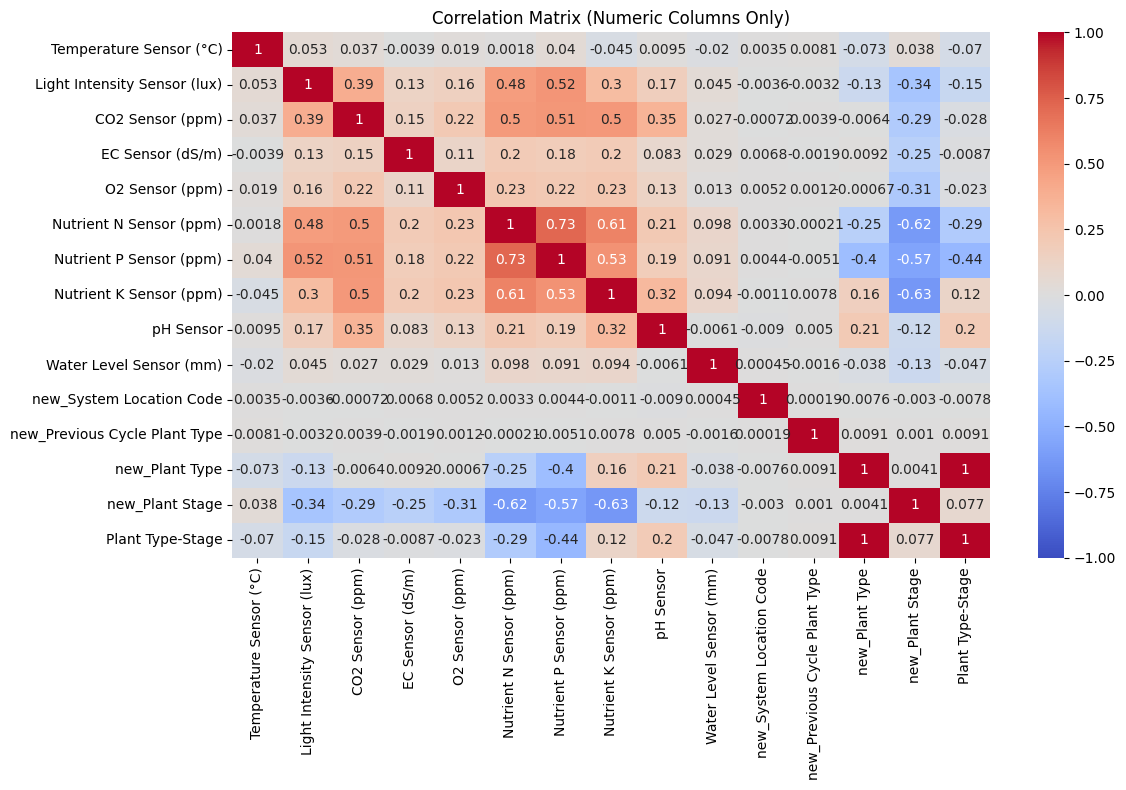

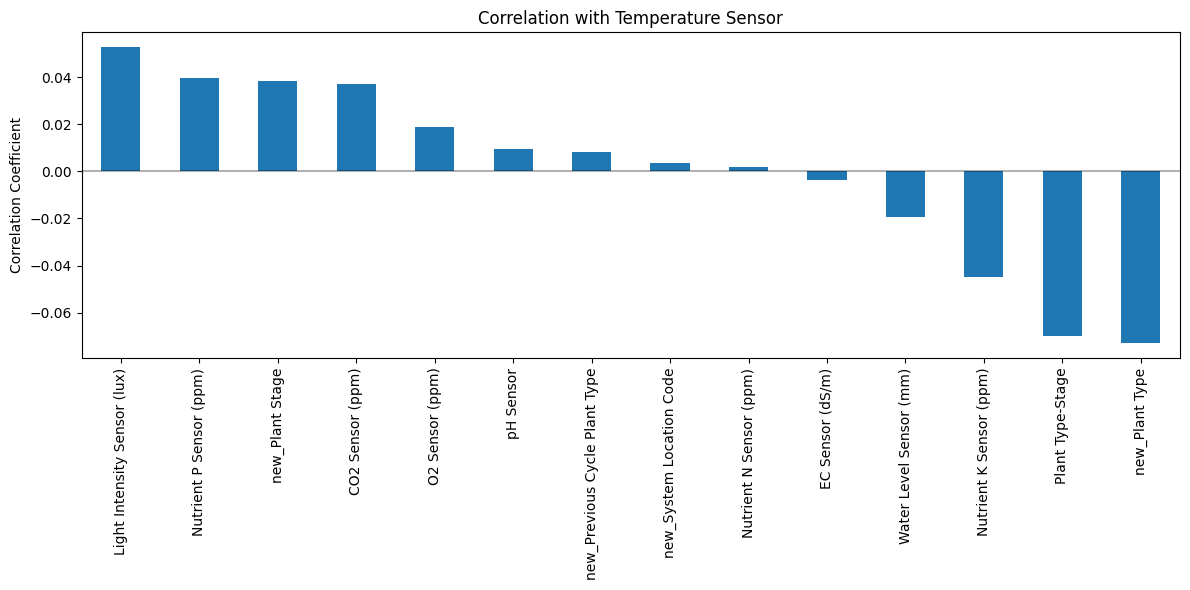

In [39]:
numeric_columns = df_new.select_dtypes(include=['int64', 'float64']).columns

# Calculate correlations with Temperature Sensor using only numeric columns
correlations = df_new[numeric_columns].corr()['Temperature Sensor (°C)'].sort_values(ascending=False)

# Print the correlations
print(correlations)

# Create a visualization using only numeric columns
plt.figure(figsize=(12, 8))
sns.heatmap(df_new[numeric_columns].corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix (Numeric Columns Only)')
plt.tight_layout()
plt.show()

# Bar chart for Temperature correlations
plt.figure(figsize=(12, 6))
correlations.drop('Temperature Sensor (°C)', errors='ignore').plot(kind='bar')
plt.title('Correlation with Temperature Sensor')
plt.ylabel('Correlation Coefficient')
plt.axhline(y=0, color='k', linestyle='-', alpha=0.3)
plt.tight_layout()
plt.show()

we can see that:
1. Light Intensity Sensor (lux) has a positive but weak relation meaning light intensity can increase the temperature.

2. Plant Type-Stage has a negative relation meaning different plant types and growth stages may have varying temperature requirements or effects on the environment.

3. new_Plant Type has a negative relation.

I will now fix the missing values of the data and test which method will increase the correlation.

In [40]:
for col in df_new.columns:
    missing_percentage = (df_new[col].isnull().sum() / len(df_new)) * 100
    print(f"Percentage of missing values in '{col}': {missing_percentage:.2f}%")

Percentage of missing values in 'Temperature Sensor (°C)': 15.11%
Percentage of missing values in 'Light Intensity Sensor (lux)': 7.44%
Percentage of missing values in 'CO2 Sensor (ppm)': 0.00%
Percentage of missing values in 'EC Sensor (dS/m)': 0.00%
Percentage of missing values in 'O2 Sensor (ppm)': 0.00%
Percentage of missing values in 'Nutrient N Sensor (ppm)': 17.35%
Percentage of missing values in 'Nutrient P Sensor (ppm)': 9.91%
Percentage of missing values in 'Nutrient K Sensor (ppm)': 6.44%
Percentage of missing values in 'pH Sensor': 0.00%
Percentage of missing values in 'Water Level Sensor (mm)': 15.03%
Percentage of missing values in 'new_System Location Code': 0.00%
Percentage of missing values in 'new_Previous Cycle Plant Type': 0.00%
Percentage of missing values in 'new_Plant Type': 0.00%
Percentage of missing values in 'new_Plant Stage': 0.00%
Percentage of missing values in 'Plant Type-Stage': 0.00%


In [41]:
fill_up = ["Temperature Sensor (°C)", "Light Intensity Sensor (lux)", "Nutrient N Sensor (ppm)", "Nutrient P Sensor (ppm)", "Nutrient K Sensor (ppm)", "Water Level Sensor (mm)"]

df_filled = df_new.copy()  # Use parentheses to call the copy method

# Initialize the KNNImputer
knn_imputer = KNNImputer(n_neighbors=5)  # Uses 5 nearest neighbors

# Apply KNN imputation only to the selected columns in the new DataFrame
df_filled[fill_up] = knn_imputer.fit_transform(df_filled[fill_up])

# Print the new DataFrame
print(df_filled)

       Temperature Sensor (°C)  Light Intensity Sensor (lux)  \
0                       23.340                         454.0   
1                      -24.160                         441.0   
2                       23.840                         562.0   
3                       22.610                         651.0   
4                       22.880                         144.0   
...                        ...                           ...   
57484                   23.106                         619.0   
57485                   23.106                         619.0   
57486                   24.850                         203.0   
57487                   23.450                         502.0   
57488                   20.000                         391.0   

       CO2 Sensor (ppm)  EC Sensor (dS/m)  O2 Sensor (ppm)  \
0                   937              1.82                4   
1                   938              2.13                6   
2                  1246              1.21    

In [42]:
#check if all columns are filled

for col in df_filled.columns:
    missing_percentage = (df_filled[col].isnull().sum() / len(df_filled)) * 100
    print(f"Percentage of missing values in '{col}': {missing_percentage:.2f}%")


Percentage of missing values in 'Temperature Sensor (°C)': 0.00%
Percentage of missing values in 'Light Intensity Sensor (lux)': 0.00%
Percentage of missing values in 'CO2 Sensor (ppm)': 0.00%
Percentage of missing values in 'EC Sensor (dS/m)': 0.00%
Percentage of missing values in 'O2 Sensor (ppm)': 0.00%
Percentage of missing values in 'Nutrient N Sensor (ppm)': 0.00%
Percentage of missing values in 'Nutrient P Sensor (ppm)': 0.00%
Percentage of missing values in 'Nutrient K Sensor (ppm)': 0.00%
Percentage of missing values in 'pH Sensor': 0.00%
Percentage of missing values in 'Water Level Sensor (mm)': 0.00%
Percentage of missing values in 'new_System Location Code': 0.00%
Percentage of missing values in 'new_Previous Cycle Plant Type': 0.00%
Percentage of missing values in 'new_Plant Type': 0.00%
Percentage of missing values in 'new_Plant Stage': 0.00%
Percentage of missing values in 'Plant Type-Stage': 0.00%


Temperature Sensor (°C)          1.000000
Light Intensity Sensor (lux)     0.041736
new_Plant Stage                  0.040529
CO2 Sensor (ppm)                 0.033236
Nutrient P Sensor (ppm)          0.031089
O2 Sensor (ppm)                  0.017868
pH Sensor                        0.010121
new_Previous Cycle Plant Type    0.007603
new_System Location Code         0.002523
Nutrient N Sensor (ppm)         -0.004847
EC Sensor (dS/m)                -0.005296
Water Level Sensor (mm)         -0.026162
Nutrient K Sensor (ppm)         -0.044814
Plant Type-Stage                -0.065262
new_Plant Type                  -0.068424
Name: Temperature Sensor (°C), dtype: float64


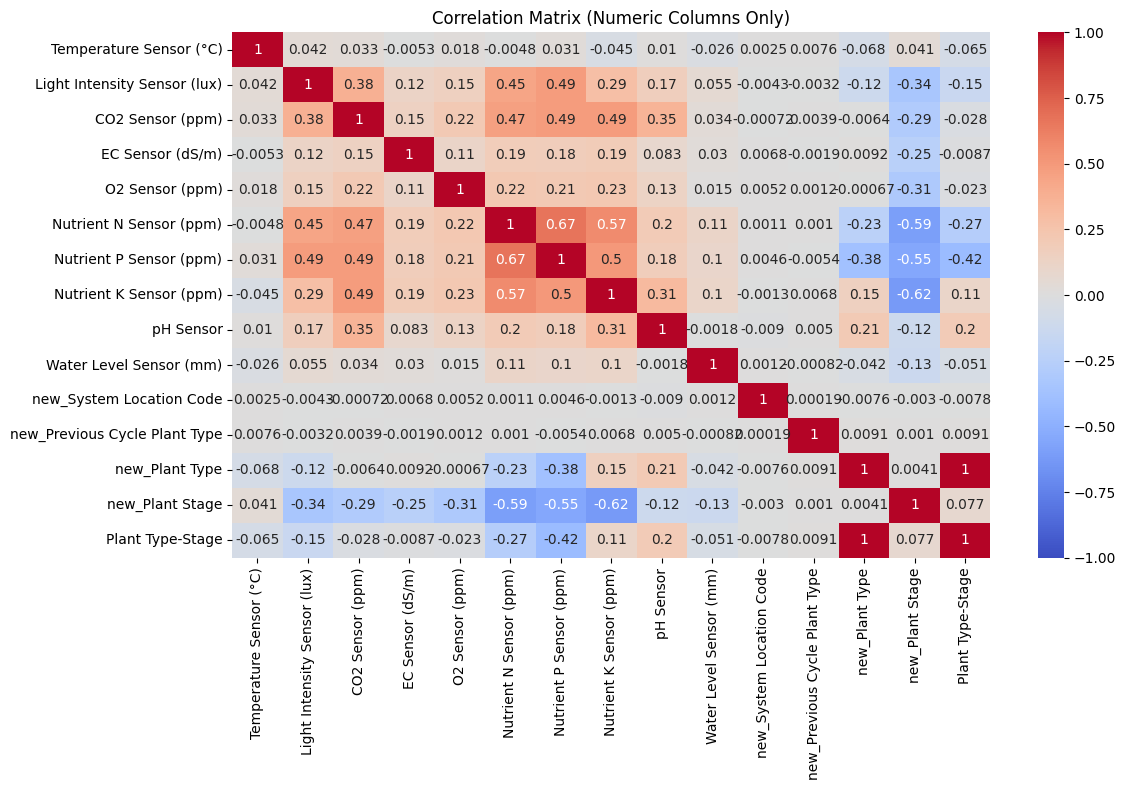

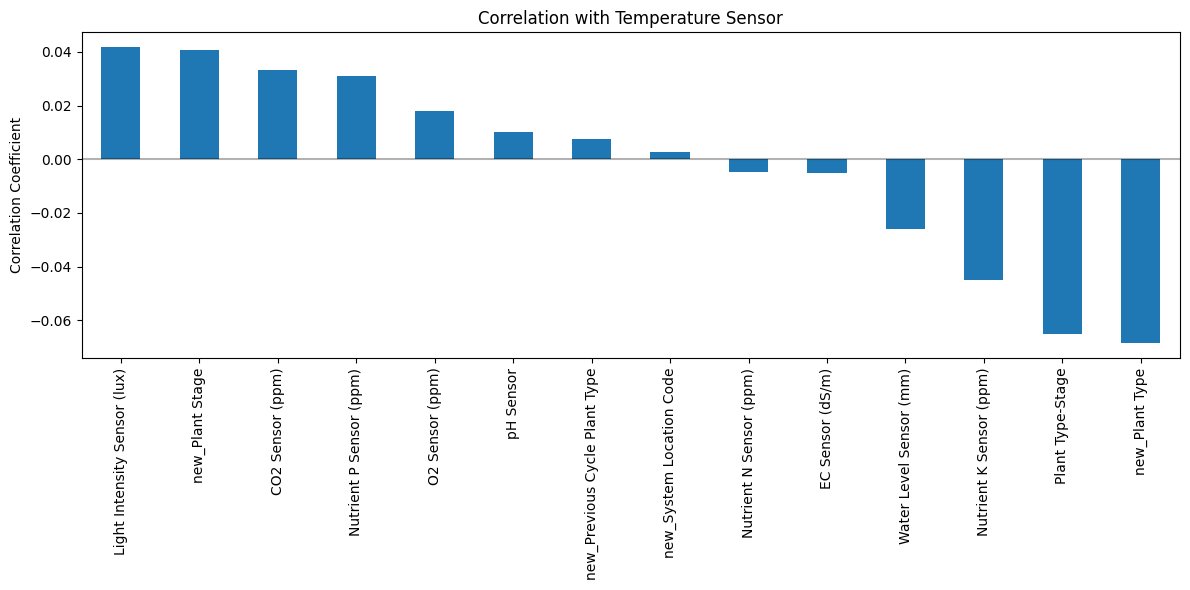

In [43]:
# Calculate correlations with Temperature Sensor using only numeric columns
correlations = df_filled[numeric_columns].corr()['Temperature Sensor (°C)'].sort_values(ascending=False)

# Print the correlations
print(correlations)

# Create a visualization using only numeric columns
plt.figure(figsize=(12, 8))
sns.heatmap(df_filled[numeric_columns].corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix (Numeric Columns Only)')
plt.tight_layout()
plt.show()

# Bar chart for Temperature correlations
plt.figure(figsize=(12, 6))
correlations.drop('Temperature Sensor (°C)', errors='ignore').plot(kind='bar')
plt.title('Correlation with Temperature Sensor')
plt.ylabel('Correlation Coefficient')
plt.axhline(y=0, color='k', linestyle='-', alpha=0.3)
plt.tight_layout()
plt.show()

We can see that by filling up the rows with missing valuers, the correlation actually decreased. Hence, I will check if removing rows with the missing values would improve the correlation instead.

In [44]:
df_new = df_new.dropna()

for col in df_new.columns:
    missing_percentage = (df_new[col].isnull().sum() / len(df_new)) * 100
    print(f"Percentage of missing values in '{col}': {missing_percentage:.2f}%")

Percentage of missing values in 'Temperature Sensor (°C)': 0.00%
Percentage of missing values in 'Light Intensity Sensor (lux)': 0.00%
Percentage of missing values in 'CO2 Sensor (ppm)': 0.00%
Percentage of missing values in 'EC Sensor (dS/m)': 0.00%
Percentage of missing values in 'O2 Sensor (ppm)': 0.00%
Percentage of missing values in 'Nutrient N Sensor (ppm)': 0.00%
Percentage of missing values in 'Nutrient P Sensor (ppm)': 0.00%
Percentage of missing values in 'Nutrient K Sensor (ppm)': 0.00%
Percentage of missing values in 'pH Sensor': 0.00%
Percentage of missing values in 'Water Level Sensor (mm)': 0.00%
Percentage of missing values in 'new_System Location Code': 0.00%
Percentage of missing values in 'new_Previous Cycle Plant Type': 0.00%
Percentage of missing values in 'new_Plant Type': 0.00%
Percentage of missing values in 'new_Plant Stage': 0.00%
Percentage of missing values in 'Plant Type-Stage': 0.00%


Temperature Sensor (°C)          1.000000
Light Intensity Sensor (lux)     0.049840
Nutrient P Sensor (ppm)          0.042134
new_Plant Stage                  0.038983
CO2 Sensor (ppm)                 0.037712
new_Previous Cycle Plant Type    0.011974
pH Sensor                        0.011248
O2 Sensor (ppm)                  0.008178
new_System Location Code         0.002893
Nutrient N Sensor (ppm)          0.002318
EC Sensor (dS/m)                -0.004845
Water Level Sensor (mm)         -0.019771
Nutrient K Sensor (ppm)         -0.045660
Plant Type-Stage                -0.075893
new_Plant Type                  -0.078966
Name: Temperature Sensor (°C), dtype: float64


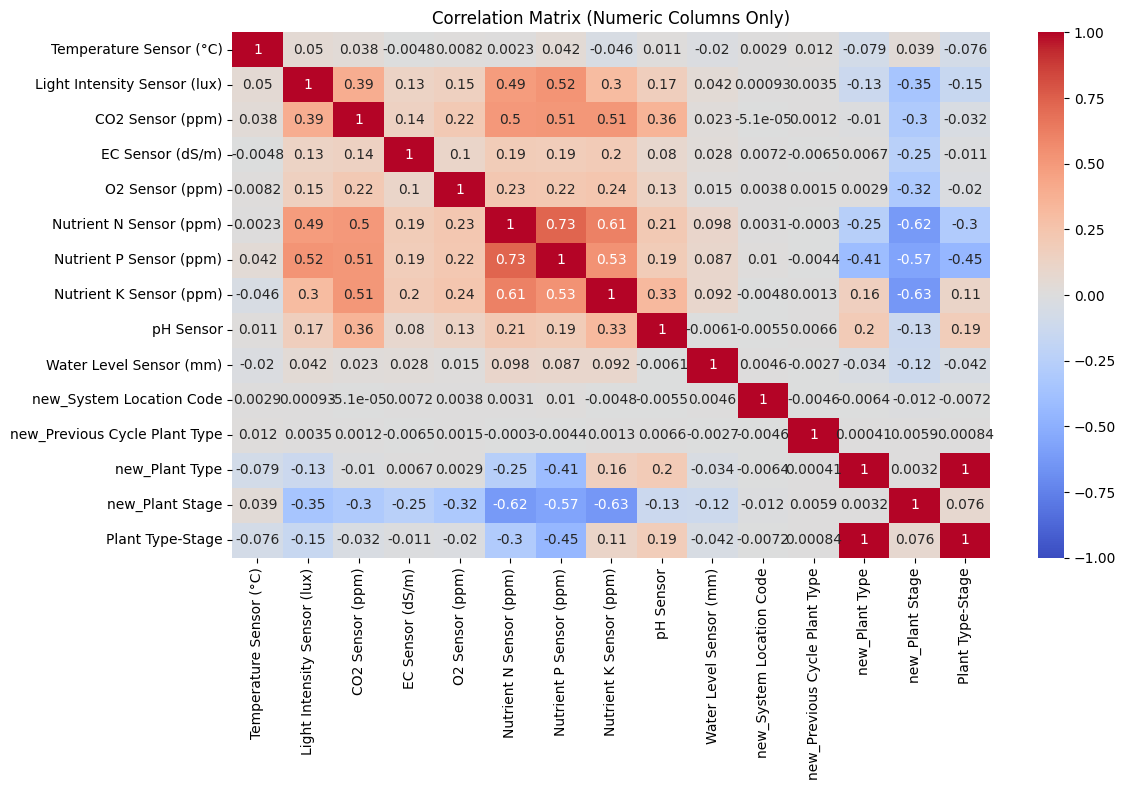

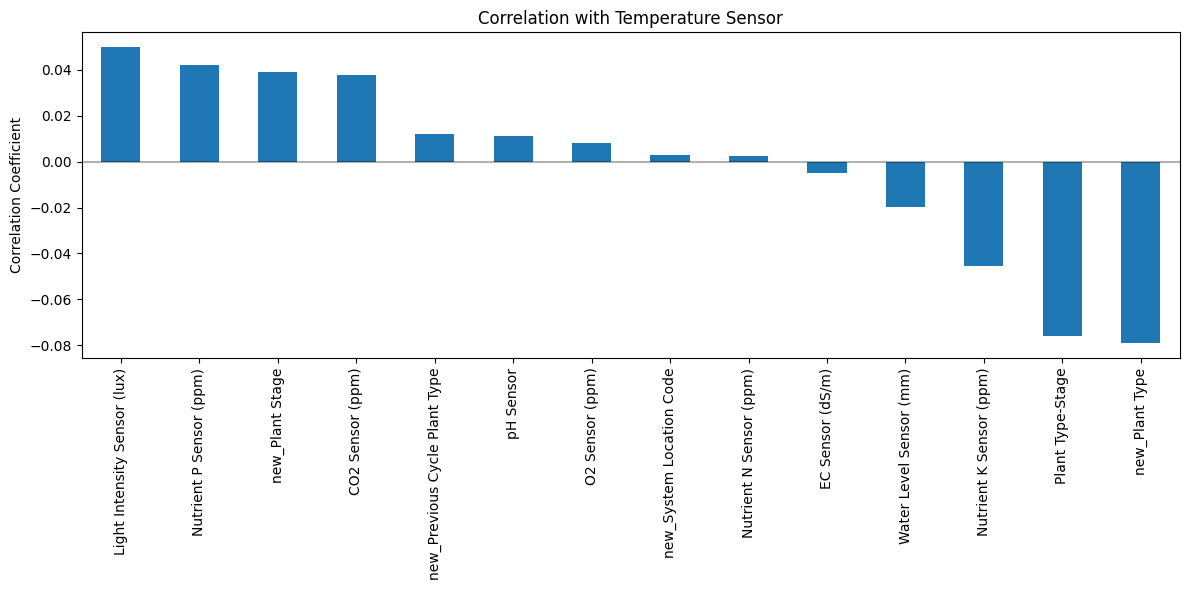

In [45]:
correlations = df_new[numeric_columns].corr()['Temperature Sensor (°C)'].sort_values(ascending=False)

# Print the correlations
print(correlations)

# Create a visualization using only numeric columns
plt.figure(figsize=(12, 8))
sns.heatmap(df_new[numeric_columns].corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix (Numeric Columns Only)')
plt.tight_layout()
plt.show()

# Bar chart for Temperature correlations
plt.figure(figsize=(12, 6))
correlations.drop('Temperature Sensor (°C)', errors='ignore').plot(kind='bar')
plt.title('Correlation with Temperature Sensor')
plt.ylabel('Correlation Coefficient')
plt.axhline(y=0, color='k', linestyle='-', alpha=0.3)
plt.tight_layout()
plt.show()

In [46]:
print(df_new)

       Temperature Sensor (°C)  Light Intensity Sensor (lux)  \
0                        23.34                         454.0   
2                        23.84                         562.0   
4                        22.88                         144.0   
5                        25.96                         675.0   
9                        25.59                         435.0   
...                        ...                           ...   
57481                    20.70                         371.0   
57483                    25.79                         262.0   
57486                    24.85                         203.0   
57487                    23.45                         502.0   
57488                    20.00                         391.0   

       CO2 Sensor (ppm)  EC Sensor (dS/m)  O2 Sensor (ppm)  \
0                   937              1.82                4   
2                  1246              1.21                8   
4                   812              2.76    

We can see that the correlation improved slightly. Hence, I will be removing rows with missing values.

Now I will be using different models and test which model performs better then creating a predictive model for temperature condition.

In [47]:
# 1. Prepare features and target
X = df_new.drop('Temperature Sensor (°C)', axis=1)  # All other columns as features
y = df_new['Temperature Sensor (°C)']               # Temperature as target

# 2. Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. Scale the features (important for many ML algorithms)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [48]:
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0),
    'Lasso Regression': Lasso(alpha=0.1),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42)
}


results = {}
feature_importances = {}

for name, model in models.items():
    # Train the model
    model.fit(X_train_scaled, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test_scaled)
    
    # Evaluate
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100  # MAPE in percentage
    
    results[name] = {'MSE': mse, 'RMSE': rmse, 'MAE': mae, 'R2': r2, 'MAPE': mape}
    
    # Store feature importances if available
    if hasattr(model, 'feature_importances_'):
        feature_importances[name] = pd.Series(
            model.feature_importances_,
            index=X.columns
        ).sort_values(ascending=False)
    elif hasattr(model, 'coef_'):
        feature_importances[name] = pd.Series(
            np.abs(model.coef_),
            index=X.columns
        ).sort_values(ascending=False)


Model Performance:
Linear Regression: MSE = 53.2998, RMSE = 7.3007, MAE = 2.4519, R2 = 0.0174, MAPE = 10.28%
Ridge Regression: MSE = 53.2998, RMSE = 7.3007, MAE = 2.4519, R2 = 0.0174, MAPE = 10.28%
Lasso Regression: MSE = 53.4835, RMSE = 7.3132, MAE = 2.4649, R2 = 0.0140, MAPE = 10.32%
Random Forest: MSE = 48.2917, RMSE = 6.9492, MAE = 2.5869, R2 = 0.1097, MAPE = 10.98%
Gradient Boosting: MSE = 52.4808, RMSE = 7.2444, MAE = 2.3541, R2 = 0.0325, MAPE = 9.93%

Best model: Random Forest with R2 = 0.1097


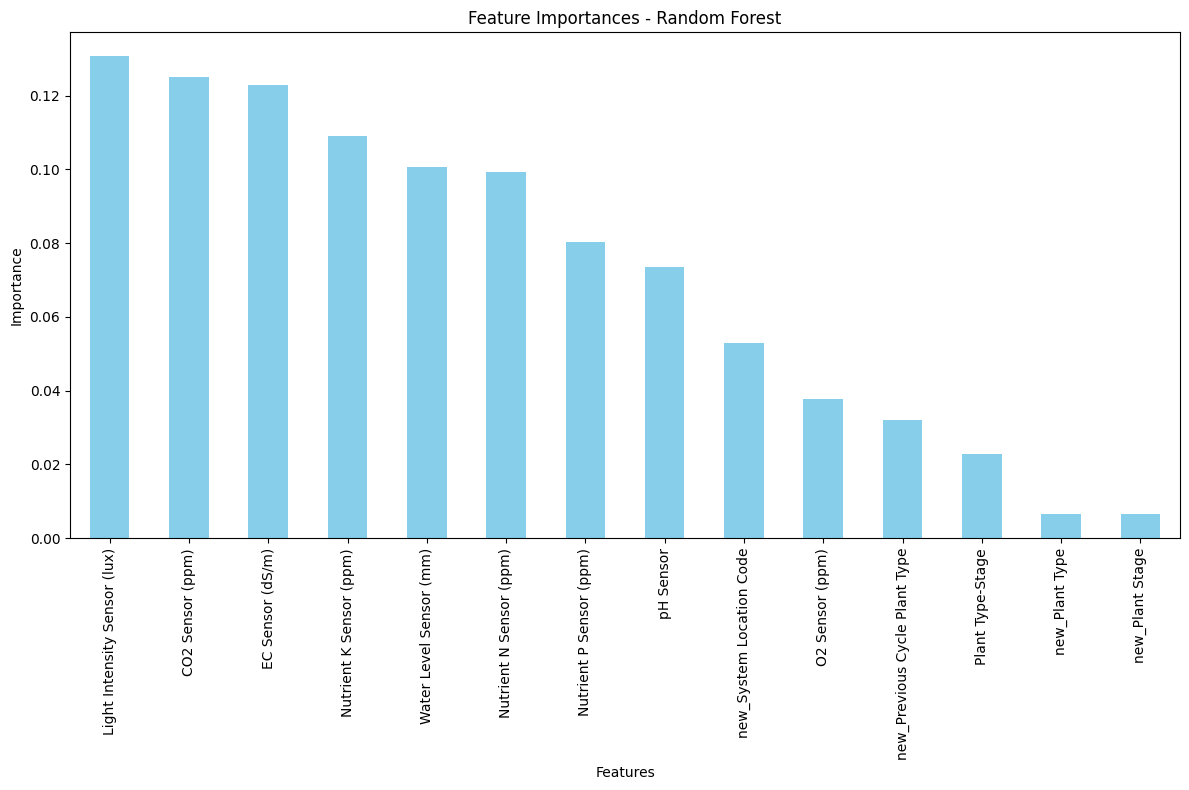


Cross-Validation R2 Scores: [0.12938039 0.10338178 0.1192538  0.0810668  0.13612627]
Mean Cross-Validation R2 Score: 0.1138
95% Confidence Interval for R2: (np.float64(0.09652766688356772), np.float64(0.13115594279325804))


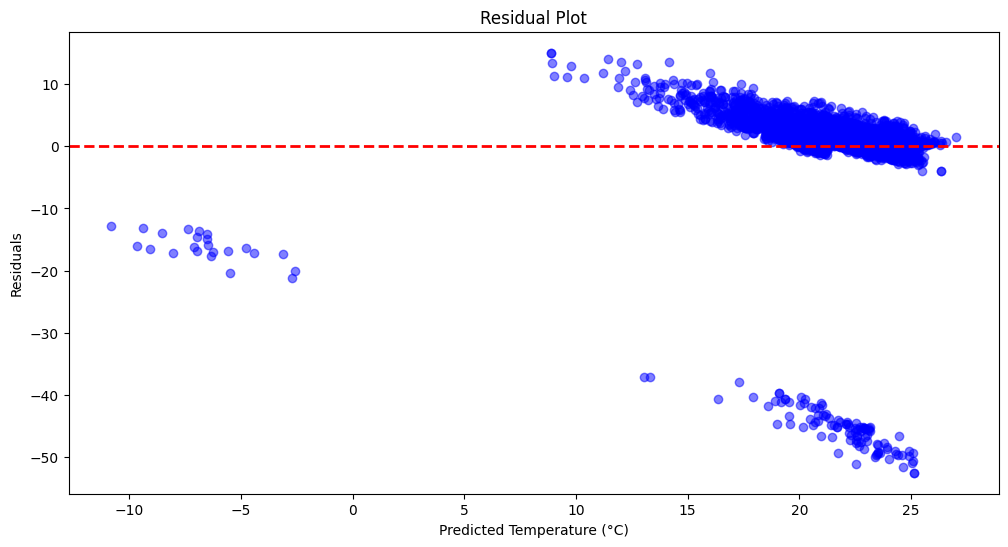

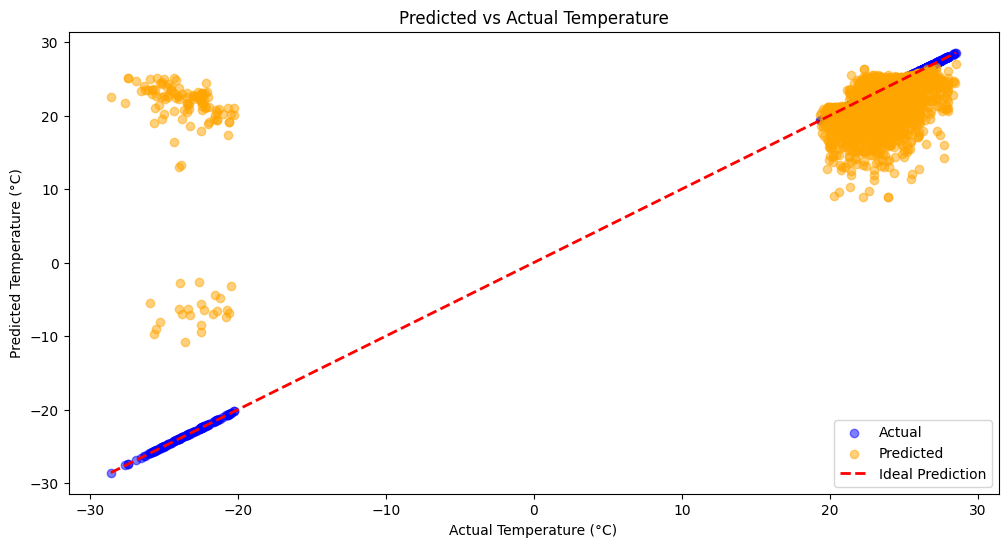

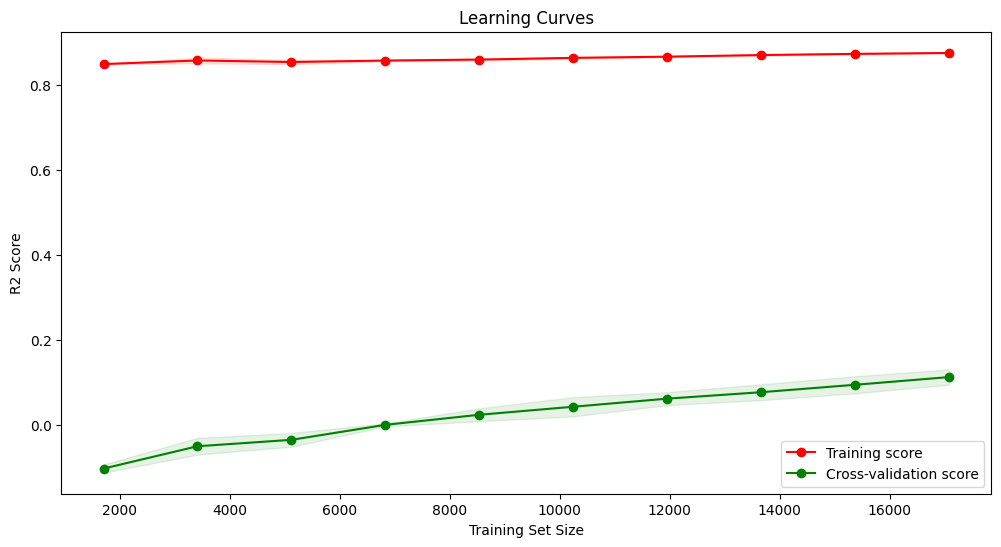

In [50]:
print("Model Performance:")
for name, metrics in results.items():
    print(f"{name}: MSE = {metrics['MSE']:.4f}, RMSE = {metrics['RMSE']:.4f}, MAE = {metrics['MAE']:.4f}, R2 = {metrics['R2']:.4f}, MAPE = {metrics['MAPE']:.2f}%")

# Identify the best model based on R2 score
best_model_name = max(results, key=lambda x: results[x]['R2'])
print(f"\nBest model: {best_model_name} with R2 = {results[best_model_name]['R2']:.4f}")

# Plot feature importances if available
if best_model_name in feature_importances:
    plt.figure(figsize=(12, 8))
    feature_importances[best_model_name].plot(kind='bar', color='skyblue')
    plt.title(f'Feature Importances - {best_model_name}')
    plt.xlabel('Features')
    plt.ylabel('Importance')
    plt.tight_layout()
    plt.show()
    
best_model = models[best_model_name]

# Cross-validation for the best model
cv_scores = cross_val_score(best_model, X_train_scaled, y_train, cv=5, scoring='r2')
print(f"\nCross-Validation R2 Scores: {cv_scores}")
print(f"Mean Cross-Validation R2 Score: {cv_scores.mean():.4f}")

# Confidence interval for R2
confidence = 0.95
ci = stats.norm.interval(confidence, loc=cv_scores.mean(), scale=cv_scores.std() / np.sqrt(len(cv_scores)))
print(f"95% Confidence Interval for R2: {ci}")

# Residual analysis
y_pred = best_model.predict(X_test_scaled)
residuals = y_test - y_pred

plt.figure(figsize=(12, 6))
plt.scatter(y_pred, residuals, alpha=0.5, color='blue')
plt.axhline(y=0, color='r', linestyle='--', lw=2)
plt.xlabel('Predicted Temperature (°C)')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

# Predicted vs Actual plot with different colors
plt.figure(figsize=(12, 6))
plt.scatter(y_test, y_test, color='blue', alpha=0.5, label='Actual')  # Actual values in blue
plt.scatter(y_test, y_pred, color='orange', alpha=0.5, label='Predicted')  # Predicted values in orange
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Ideal Prediction')  # Ideal line
plt.xlabel('Actual Temperature (°C)')
plt.ylabel('Predicted Temperature (°C)')
plt.title('Predicted vs Actual Temperature')
plt.legend(loc='best')
plt.show()

# Learning curves
train_sizes, train_scores, test_scores = learning_curve(
    best_model, X_train_scaled, y_train, cv=5, scoring='r2', train_sizes=np.linspace(0.1, 1.0, 10)
)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure(figsize=(12, 6))
plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training score')
plt.plot(train_sizes, test_scores_mean, 'o-', color='g', label='Cross-validation score')
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color='r')
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color='g')
plt.title('Learning Curves')
plt.xlabel('Training Set Size')
plt.ylabel('R2 Score')
plt.legend(loc='best')
plt.show()

We can see that the model is not optimised to predict negative temperature which could be due to error and inconsistency in the dataset.

Test the model

In [ ]:
def predict_temperature(data, model_name=best_model_name):
    model = models[model_name]
    # Ensure data is in the right format
    if isinstance(data, pd.DataFrame):
        # Scale the data
        scaled_data = scaler.transform(data)
    else:
        # Assume it's already a numpy array (scaled)
        scaled_data = data
    
    return model.predict(scaled_data)

Method 2: Using deep nueral network model